# Overview 
Sparkify is a music streaming service just as Spotify and Pandora.

The data provided is the user log of the service, having demographic info, user activities, timestamps and etc. We try to analyze the log and build a model to identify customers who are highly likely to quit using our service, and thus, send marketing offers to them to prevent them from churning.

We use F1 score to measure of model performance because we need precision and recall at the same time as we don't want to miss too many customers who are likely to churn whilst we don't want to waste too much on those who are not likely to churn.

We performed EDA to establish features, and train several machine learning classification models.

The model we built and selected has a F1 score of 0.800, which is 16% higher than sending everybody offers. There is also a short article about this project posted here.

The problem that I will attempt to solve will be to predict customer churn in advance and I will be using spark (PySpark) and the Gradient boosting models classification.

In [1]:
# Import libraries
from pyspark.sql import SparkSession

import numpy as np
import pandas as pd
import math
import datetime
import re

import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LogisticRegression, GBTClassifier, NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [2]:
# Create a Spark session
spark = SparkSession.builder.appName('Sparkify').getOrCreate()

# Load and Clean Dataset

In [3]:
# Load the data and check the schema
path = 'mini_sparkify_event_data.json'
df = spark.read.json(path)

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [6]:
# Check for missing values
from pyspark.sql.functions import isnan, when, count, col

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



We can see that, the numbers of missing values in the columns of gender, firstName, lastName, registration, location, and userAgent are the same, which makes sense since these are related to the user information, but there is no missing values in the userID and sessionID columns which should have the similar number of missing values as they are also related to the user information, so further examinations on empty entries should be conducted. 

In [7]:
# Check the columns with the same number of missing values
df.select(df.columns).where(isnan('gender') | col('gender').isNull()).show(10)

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET| Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355841000|     null|      |
|  null|Logged Out|     null|  nul

In [8]:
df.filter(df['sessionId']=='').count()

0

In [9]:
df.filter(df['userID']=='').count()

8346

The number of empty entries in the userID column is the same of those numbers of missing values. Since the empty userID entry may be a result from unlogged user, these rows are not significant for our further analysis, the next step will be removing the rows with empty entries in the userID column and check the missing values again.

In [10]:
df_clean = df.filter(df['userID']!='')

df_clean.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_clean.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



Now, we have no missing values in the columns related to user information. The missing values in the song-related information columns, including artist, length, and song, are reasonable as many events don't involve listening to a song and these can be treated as a feature later in the modeling, so we will keep these rows in the dataframe now.

In [11]:
# Check the unique values in the categorical columns
df.select('auth').distinct().show(), df.select('level').distinct().show(), df.select('method').distinct().show(), 
df.select('page').distinct().show(), df.select('status').distinct().show()

+----------+
|      auth|
+----------+
|Logged Out|
| Cancelled|
|     Guest|
| Logged In|
+----------+

+-----+
|level|
+-----+
| free|
| paid|
+-----+

+------+
|method|
+------+
|   PUT|
|   GET|
+------+

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



(None, None)

In [12]:
# Check the unique values in the categorical columns in the cleaned dataset
df_clean.select('auth').distinct().show(), df_clean.select('level').distinct().show(), df_clean.select('method').distinct().show(), 
df_clean.select('page').distinct().show(), df_clean.select('status').distinct().show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+

+-----+
|level|
+-----+
| free|
| paid|
+-----+

+------+
|method|
+------+
|   PUT|
|   GET|
+------+

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



(None, None)

It is interesting to see that after removing those rows with missing/empty values in userID, there less categeories in the columns of auth and page, which are Logged Out/Guest, and Login/Register/Submit Registration as expected. Only guests or those logged out don't have user information and logged-in users can't log in again or register for an account.

# Exploratory Data Analysis

### Initial Analysis

In [13]:
# Convert the ts and registration column to regular time format
time_transfer = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000).strftime('%Y-%m-%d %H:%M:%S'))
df_clean = df_clean.withColumn('time', time_transfer(df['ts']))
df_clean = df_clean.withColumn('registrationTime', time_transfer(df['registration']))

In [14]:
df_clean.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', time='2018-10-01 00:01:57', registrationTime='2018-09-28 22:22:42')

In [15]:
df_clean.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- time: string (nullable = true)
 |-- registrationTime: string (nullable = true)



In [16]:
df_clean.count()

278154

In [17]:
# Check the number of users in the data
df_clean.select('userID').dropDuplicates().count()

225

In [18]:
df_clean.select('userAgent').distinct().count()

56

In [19]:
df_clean.select('status').distinct().show()

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



In [20]:
# Check the statistics of the numerical column of length
df_clean.select('length').describe().show()

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|           228108|
|   mean|249.1171819778458|
| stddev|99.23517921058361|
|    min|          0.78322|
|    max|       3024.66567|
+-------+-----------------+



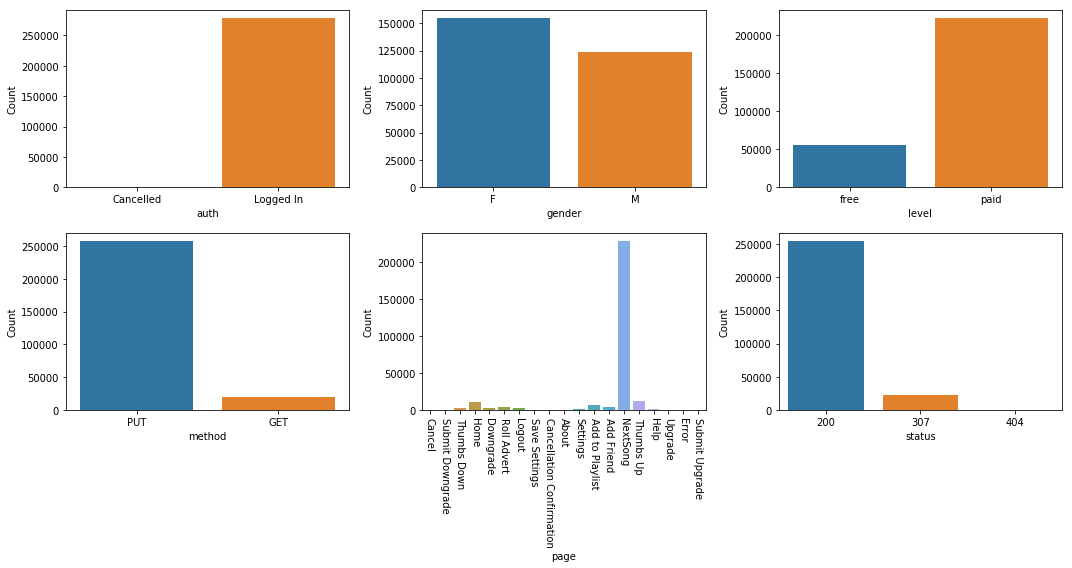

In [21]:
# Visualize the distributions of the categorical columns
cat_cols = ['auth', 'gender', 'level', 'method', 'page', 'status']

fig, axs = plt.subplots(nrows=2, ncols=3, figsize = (15, 8))

i = 0

for col in cat_cols:
    temp_df = df_clean.groupBy(col).count().toPandas()
    ax1 = axs[math.floor(i / 3), i % 3]
    sns.barplot(temp_df[col], temp_df['count'], ax = ax1)
    ax1.set_xlabel(col)
    ax1.set_ylabel('Count')
    ax1.legend(loc=0)
    if col == 'page':
        ax1.tick_params(axis='x', rotation = -90)
    i += 1
    
plt.tight_layout()

plt.show()
plt.savefig('figs/dist_cat.png', dpi = 300, bbox_inches='tight')

From the observations above, one most significant finding is that for most of the categorical columns, the distribution is strongly skewed.

### Define Churn

Create a column `Churn` to use as the label for the model. Here, I chose to use the `Cancellation Confirmation` event in the `page` column to define the churn, which happen for both paid and free users.

In [22]:
df_clean.select('page').distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [23]:
df_clean.filter((df['auth']!='Cancelled') & (df['page']=='Cancellation Confirmation')).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+----+----------------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|time|registrationTime|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+----+----------------+
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+----+----------------+



In [24]:
df_clean.filter(df['page']=='Cancellation Confirmation').select('auth').dropDuplicates().show()

+---------+
|     auth|
+---------+
|Cancelled|
+---------+



In [25]:
df_clean.filter(df['page']=='Cancellation Confirmation').count()

52

In [26]:
df_clean.filter(df['page']=='Cancellation Confirmation').select('userID').dropDuplicates().count()

52

We observe that no duplicate user ID is present with the `Cancellation Confirmation` event and only those with a `Cancelled` auth status can have the `Cancellation Confirmation` event. Then,we will define the churn column, which is labeled 1 if the user ID in the same row has ever performed a `Cancellation Confirmation` event.

In [27]:
# Define the list of the user IDs who have ever had the cancellation confirmation event
user_churned = df_clean.filter(df['page']=='Cancellation Confirmation').select('userID').dropDuplicates()
user_churned_list = [r['userID'] for r in user_churned.collect()]

In [28]:
# Create the churn column

# Define the udf to extract the churn label
is_churn_udf = udf(lambda x: 1 if x in user_churned_list else 0, IntegerType())
df_clean = df_clean.withColumn('churn', is_churn_udf('userID'))

In [29]:
df_clean.filter(df_clean['churn']==0).count()

233290

In [30]:
df_clean.count()

278154

In [31]:
# df_with_target = df_clean.withColumn('churn', df['userID'].isin(user_churned_list))
# df_with_target.filter(df_with_target['churn']==False).count()

In addition, downgrading may be another interesting target variable to study, which is reflected by the `Submit Downgrade` event in the `page` column. We'll also include it here using the similar method above.

In [32]:
df_clean.filter(df['page']=='Submit Downgrade').select('auth').dropDuplicates().show()

+---------+
|     auth|
+---------+
|Logged In|
+---------+



In [33]:
# downgrade_value  = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
# df = df.withColumn("downgrade_value", downgrade_value("page"))

# dg_window = Window.partitionBy('UserId')
# df = df.withColumn("user_downgrade", max('downgrade_value').over(dg_window))

In [34]:
user_downgrade = df_clean.filter(df['page']=='Submit Downgrade').select('userID').dropDuplicates()
user_downgrade_list = [r['userID'] for r in user_downgrade.collect()]

In [35]:
is_downgrade_udf = udf(lambda x: 1 if x in user_downgrade_list else 0, IntegerType())
df_clean = df_clean.withColumn('downgrade', is_downgrade_udf('userID'))

In [36]:
df_clean.dropDuplicates(['userID']).select('auth', 'level', 'page', 'userId', 'churn', 'downgrade').show()

+---------+-----+--------+------+-----+---------+
|     auth|level|    page|userId|churn|downgrade|
+---------+-----+--------+------+-----+---------+
|Logged In| free|NextSong|100010|    0|        0|
|Logged In| free|NextSong|200002|    0|        0|
|Logged In| free|NextSong|   125|    1|        0|
|Logged In| paid|    Home|   124|    0|        0|
|Logged In| paid|    Home|    51|    1|        0|
|Logged In| free|NextSong|     7|    0|        0|
|Logged In| paid|    Home|    15|    0|        0|
|Logged In| paid|NextSong|    54|    1|        1|
|Logged In| free|    Home|   155|    0|        0|
|Logged In| paid|NextSong|100014|    1|        0|
|Logged In| free|NextSong|   132|    0|        0|
|Logged In| free|    Home|   154|    0|        0|
|Logged In| free|    Home|   101|    1|        0|
|Logged In| free|    Home|    11|    0|        1|
|Logged In| free|    Home|   138|    0|        0|
|Logged In| paid|NextSong|300017|    0|        0|
|Logged In| free|NextSong|100021|    1|        0|


### Explore Data
With the churn (target column) defined, it will be helpful to perform some further exploratory data analysis to see the difference in behaviors for users who stayed vs users who churned. We'll start with the patterns of the columns we currently have based on whether the user churned or not.

In [37]:
churn_count = df_clean.dropDuplicates(['userID']).groupBy('churn').count().toPandas()
churn_ratio = churn_count['count'][0] / (churn_count['count'].sum())
print('There are {} churned users and {} non-churned users, the ratio of churned users is {:.2f}%.'.format(churn_count['count'][0],
                                                                                                      churn_count['count'][1],
                                                                                                      churn_ratio * 100))

There are 52 churned users and 173 non-churned users, the ratio of churned users is 23.11%.


In [38]:
def vis_dist_pattern(df, drop_label, x_label):
    '''
    Function to visualize the difference in distribution based on some categorical feature(s) in the dataset
     
    Args:
        df: a spark Dataframe
        drop_label: a list of string(s), the name(s) of the column(s) to drop the duplicates
        x_label: a string, the name of the column for the x-axis
        
    Returns:
        None
    '''
    
    fig, ax = plt.subplots(figsize=(6, 4))
    df_temp = df.dropDuplicates(drop_label).groupBy([x_label, 'churn']).count().toPandas()
    sns.barplot(x=x_label, y='count', hue='churn', data=df_temp)
    plt.tight_layout()
    plt.show()
    plt.savefig('figs/comp_%s_on_churn.png' % x_label, dpi = 300, bbox_inches='tight')

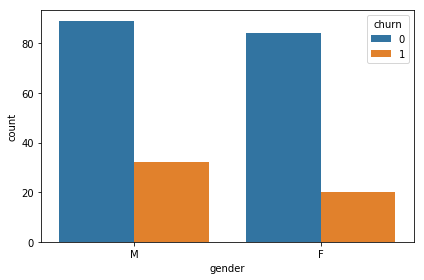

In [39]:
vis_dist_pattern(df_clean, ['userID'], 'gender')

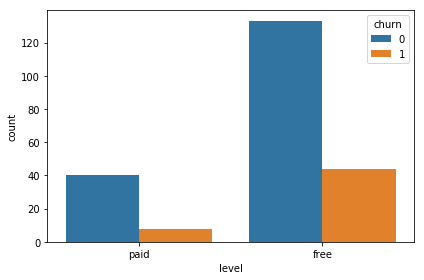

In [40]:
vis_dist_pattern(df_clean, ['userID'], 'level')

In [41]:
df_status = df_clean.groupBy(['churn','status']).count().toPandas()
tot_churn_status = df_status[df_status['churn'] == 1]['count'].sum()
tot_nonchurn_status = df_status[df_status['churn'] == 0]['count'].sum()
df_status['dist_by_churn'] = df_status.apply(lambda x: x['count'] / tot_churn_status * 100 
                                             if x['churn'] == 1 else x['count'] / tot_nonchurn_status * 100, axis=1)

df_status.sort_values(['churn', 'status'], axis=0)

,churn,status,count,dist_by_churn
4,0,200,213581,91.551717
5,0,307,19489,8.353980
2,0,404,220,0.094303
0,1,200,41137,91.692671
3,1,307,3695,8.236002
1,1,404,32,0.071327


As each user has the unique values in the `gender` and `level` column, we keep only one record of each user and check the specific patterns of these two columns.<br/>
We can see that, there tend to be more non-churned male users as well as churned male users than female users, with a higher ratio of churning for male users. Also, there is a higher chance for free users to churn and the total amount of free users are much larger than paid users.<br/>
The distribution of the `status` column is very similar for two groups of users (seems like random events), so we should probably remove this feature later (as well as the `method` column).<br/>
The `page` column is of great interests and since each user can have multiple events, we should next check the distributions of different events based on whether the user experienced the event churned.

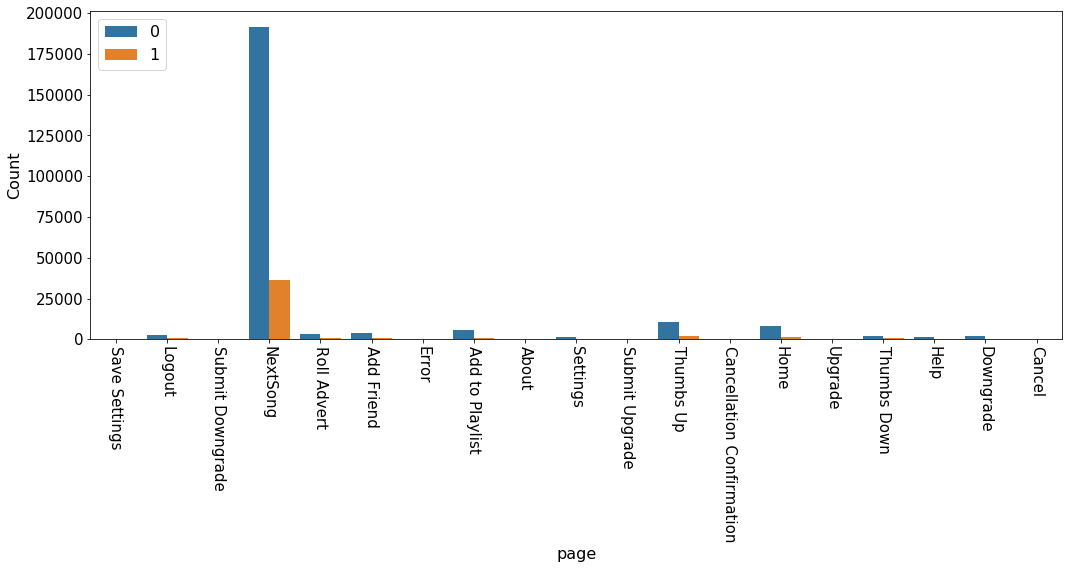

In [42]:
fig, ax = plt.subplots(figsize = (15, 8))
df_temp = df_clean.groupBy(['churn','page']).count().toPandas()
sns.barplot(x='page', y='count', hue='churn', data=df_temp, ax=ax)
ax.set_ylabel('Count', fontsize = 16)
ax.set_xlabel('page', fontsize = 16)
ax.tick_params(axis='y', labelsize = 15)
ax.tick_params(axis='x', labelsize = 15, rotation = -90)
ax.legend(loc = 0, fontsize = 16)
plt.tight_layout()
plt.show()
plt.savefig('figs/page.png', dpi=300, bbox_inches='tight')

In [43]:
# Calculate the ratio of the NextSong of unchunred users
df_temp[df_temp['page'] == 'NextSong']['count'].iloc[1] / df_temp[df_temp['page'] == 'NextSong']['count'].sum()

0.15954723201290616

Apparently, churned users has much less actions of `NextSong`. Althought this may be resulted from the smaller total amount of churned, we can check the ratio of `NextSong` of unchunred users here, which is about 16% and smaller than the ratio of the churned users of around 21%, so it still seems to have an effect from this event. And due to the large numbers of this event, other events may not be so clear, so we'll remove this column and take the unbalanced user numbers into consideration to re-check the patterns.

In [44]:
# Average number of events of the two groups of users
df_temp[df_temp['churn'] == 0]['count'].sum() / churn_count.loc[1, 'count']

1348.4971098265896

In [45]:
df_temp[df_temp['churn'] == 1]['count'].sum() / churn_count.loc[0, 'count']

862.76923076923072

In [46]:
# Take the unbalanced number of churned/non-churned users into consideration
df_temp['balanced'] = df_temp.apply(lambda x: x['count'] / churn_ratio if x['churn'] == 1 else x['count'], axis=1)

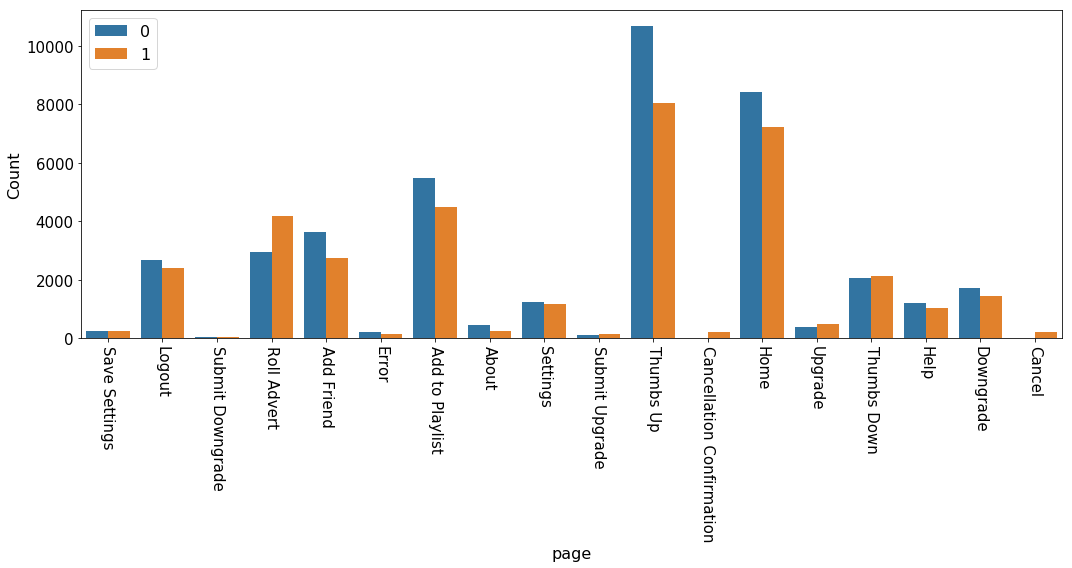

In [47]:
fig, ax = plt.subplots(figsize = (15, 8))

sns.barplot(x='page', y='balanced', hue='churn', data=df_temp[df_temp['page']!='NextSong'], ax=ax)
ax.set_ylabel('Count', fontsize = 16)
ax.set_xlabel('page', fontsize = 16)
ax.tick_params(axis='y', labelsize = 15)
ax.tick_params(axis='x', labelsize = 15, rotation = -90)
ax.legend(loc = 0, fontsize = 16)
plt.tight_layout()
plt.show()
plt.savefig('figs/page2.png', dpi=300, bbox_inches='tight')

In [48]:
def vis_dist_percentage(df, col):
    '''
    Function to visualize the distribution patterns in percentage based on two user groups in the dataset
     
    Args:
        df: a spark Dataframe
        col: a string, the name of the column to visualize
        
    Returns:
        None
    '''
    
    df_temp = df.groupBy(['churn',col]).count().toPandas()
    tot_churn_events = df_temp[df_temp['churn'] == 1]['count'].sum()
    tot_nonchurn_events = df_temp[df_temp['churn'] == 0]['count'].sum()
    df_temp['percentage_by_churn'] = df_temp.apply(lambda x: x['count'] / tot_churn_events * 100 
                                                   if x['churn'] == 1 else x['count'] / tot_nonchurn_events * 100, axis=1)
    df_temp.sort_values(['churn', col], axis=0, inplace=True)
    fig, ax = plt.subplots(figsize = (15, 8))
    
    sns.barplot(x=col, y='percentage_by_churn', hue='churn', data=df_temp, ax=ax)
    ax.set_ylabel('Percentage', fontsize = 16)
    ax.set_xlabel(col, fontsize = 16)
    ax.tick_params(axis='y', labelsize = 15)
    ax.tick_params(axis='x', labelsize = 15, rotation = -90)
    ax.legend(loc = 0, fontsize = 16)
    plt.tight_layout()
    plt.show()
    plt.savefig('figs/%s_dist_percent.png' % col, dpi=300, bbox_inches='tight')

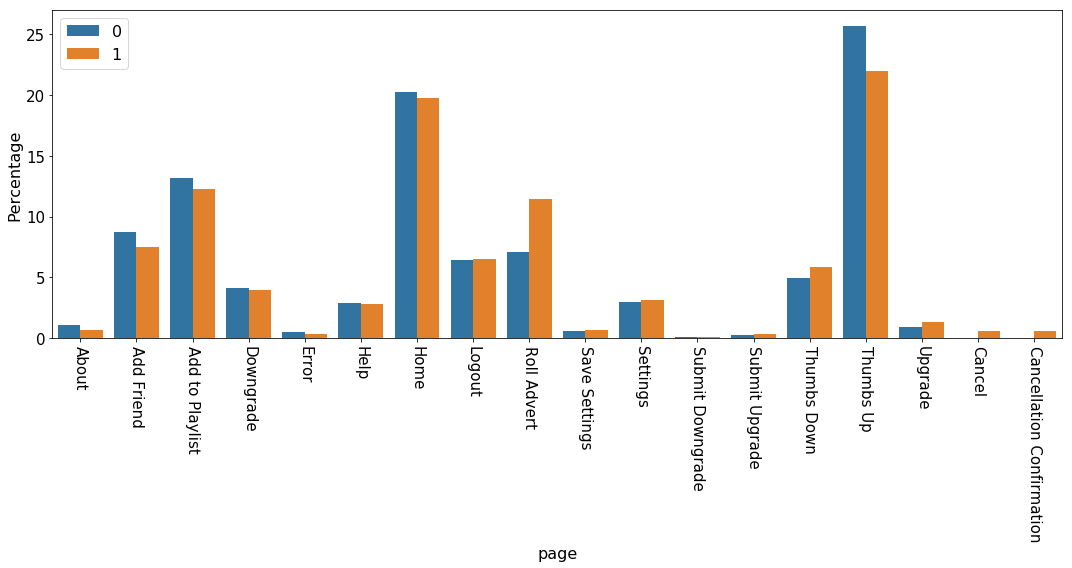

In [49]:
vis_dist_percentage(df_clean.filter(df_clean['page']!='NextSong'), 'page')

The two plots above have a similar trend, except for the `Logout`, `Home`, `Help`, and `Downgrade` events, which the trend is reversed, but since these events are originally quite similar for churned/non-churned users, such observation is fine. We can see that the most significant effects are from the `Roll Advert`, `Thumbs Up`, and `Thumbs Down` events as well as possible `Add Friend` and `Add to Playlist` events.
In these events, `Roll Advert` and `Thumbs Down` are positively related to churn while others are negatively related.<br/>
For the next step, we'll deal with the text info from the data, such as information from the `artist`, `location` and `userAgent` columns.<br/>
In addition, we can see that the non-churned users are in general more active than the churned users.

In [50]:
df_clean.select('artist').distinct().count()

17656

Too many possible artists, we'll firstly leave this out and check the other two columns.

In [51]:
df_clean.select('location').distinct().count()

114

In [52]:
df_clean.select('location').distinct().show(20, False)

+---------------------------------------+
|location                               |
+---------------------------------------+
|Gainesville, FL                        |
|Atlantic City-Hammonton, NJ            |
|Deltona-Daytona Beach-Ormond Beach, FL |
|San Diego-Carlsbad, CA                 |
|Cleveland-Elyria, OH                   |
|Kingsport-Bristol-Bristol, TN-VA       |
|New Haven-Milford, CT                  |
|Birmingham-Hoover, AL                  |
|Corpus Christi, TX                     |
|Dubuque, IA                            |
|Las Vegas-Henderson-Paradise, NV       |
|Indianapolis-Carmel-Anderson, IN       |
|Seattle-Tacoma-Bellevue, WA            |
|Albany, OR                             |
|Winston-Salem, NC                      |
|Bakersfield, CA                        |
|Los Angeles-Long Beach-Anaheim, CA     |
|Minneapolis-St. Paul-Bloomington, MN-WI|
|San Francisco-Oakland-Hayward, CA      |
|Phoenix-Mesa-Scottsdale, AZ            |
+---------------------------------

In [53]:
# Extract the state from the location
get_state_udf = udf(lambda x: x.split(',')[1].strip().split('-')[0])
df_clean = df_clean.withColumn('state', get_state_udf('location'))

In [54]:
df_clean.select('state').distinct().count()

41

In [55]:
df_clean.select('state').distinct().show(10)

+-----+
|state|
+-----+
|   AZ|
|   SC|
|   LA|
|   MN|
|   NJ|
|   DC|
|   OR|
|   VA|
|   RI|
|   KY|
+-----+
only showing top 10 rows



In [56]:
df_clean.select('userAgent').distinct().count()

56

In [57]:
df_clean.select('userAgent').distinct().show(20, False)

+-------------------------------------------------------------------------------------------------------------------------------------------+
|userAgent                                                                                                                                  |
+-------------------------------------------------------------------------------------------------------------------------------------------+
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                 |
|"Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                                   |
|Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0                                                                 |
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"                 |
|"Mozi

In [58]:
trial_str = df_clean.select('userAgent').distinct().collect()[0][0]
trial_str

'"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"'

In [59]:
pattern = r'\(([^\(\)]*)\)'
re.findall(pattern, trial_str)[0].split(';')[0]

'Macintosh'

In [60]:
# Extract the platform from the userAgent
get_os_udf = udf(lambda x: re.findall(pattern, x)[0].split(';')[0])
df_clean = df_clean.withColumn('platform', get_os_udf('userAgent'))

In [61]:
df_clean.select('platform').distinct().count()

10

In [62]:
df_clean.select('platform').distinct().show()

+--------------+
|      platform|
+--------------+
|          iPad|
|           X11|
|Windows NT 6.3|
|        iPhone|
|Windows NT 6.2|
|     Macintosh|
|Windows NT 5.1|
|    compatible|
|Windows NT 6.0|
|Windows NT 6.1|
+--------------+



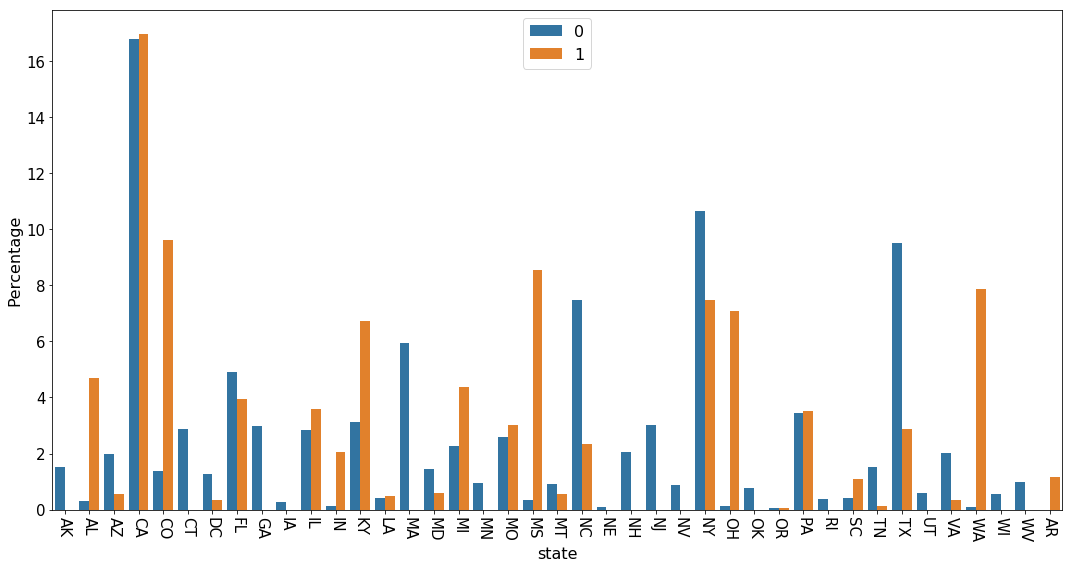

In [63]:
vis_dist_percentage(df_clean, 'state')

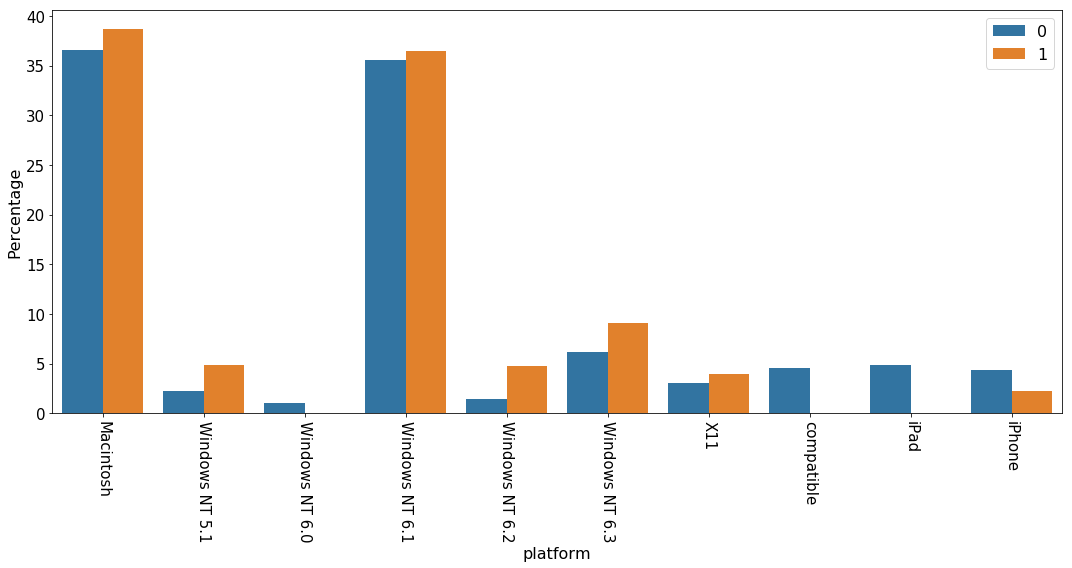

In [64]:
vis_dist_percentage(df_clean, 'platform')

We can observe some helpful patterns above. For the location-based distribution, it is interesting to find that users in some states like CO, MI, WA, MS, AL, OH, and KY contribute great to the churned group, while they contribute minor in the non-churned group.<br/>
For the platform users used, the overall distribution is similar, one interesting finding is that users using iPad and Windows NT 6.0 didn't churn. The majority of the users use Macintosh and Windows NT 6.1.

After these direct observations from the data, the next step will be exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [65]:
# Check the range of the time of the events
max_time = df_clean.groupBy().max('ts').collect()[0][0]
min_time = df_clean.groupBy().min('ts').collect()[0][0]
print('max_time: {}, min_time: {}.'
      .format(datetime.datetime.fromtimestamp(max_time / 1000).strftime('%Y-%m-%d %H:%M:%S'),
              datetime.datetime.fromtimestamp(min_time / 1000).strftime('%Y-%m-%d %H:%M:%S')))

max_time: 2018-12-03 01:11:16, min_time: 2018-10-01 00:01:57.


It seems that all these data are collected in the time interval from October 2018 to the beginning of December 2018, we can analyze the pattern based on the hours, weekday, and month.

In [66]:
get_hour_udf = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000).hour, IntegerType())
get_weekday_udf = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000).isoweekday(), IntegerType())
get_month_udf = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000).month, IntegerType())
                    
df_clean = df_clean.withColumn('hour', get_hour_udf('ts'))
df_clean = df_clean.withColumn('weekday', get_weekday_udf('ts'))
df_clean = df_clean.withColumn('month', get_month_udf('ts'))

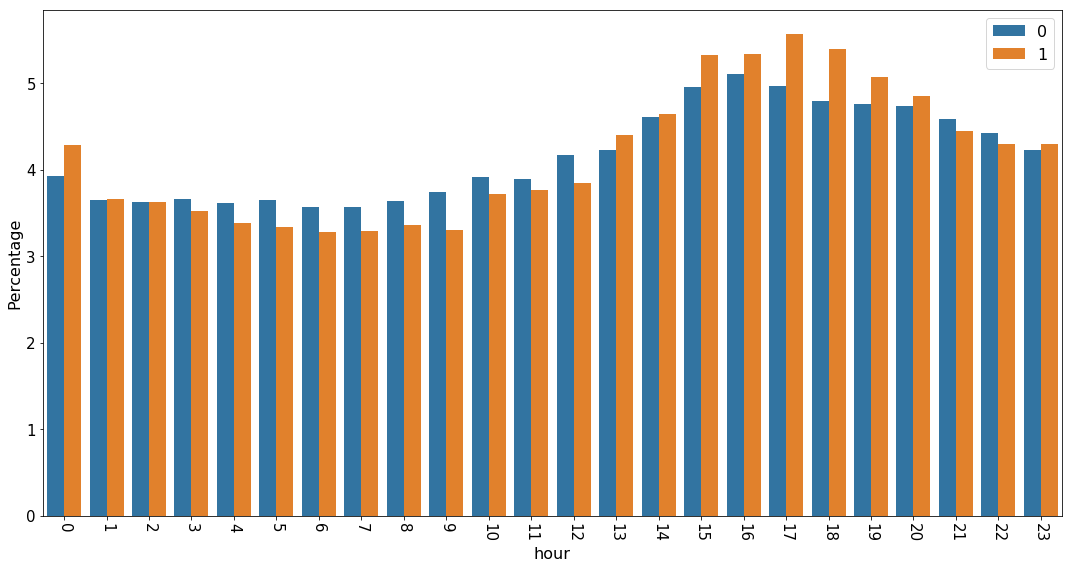

In [67]:
vis_dist_percentage(df_clean, 'hour')

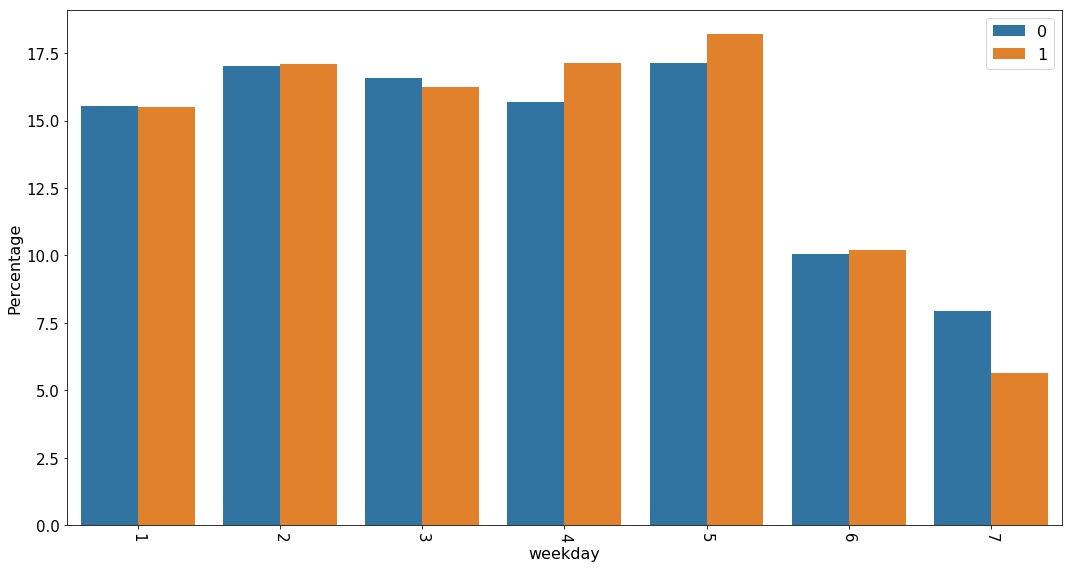

In [68]:
vis_dist_percentage(df_clean, 'weekday')

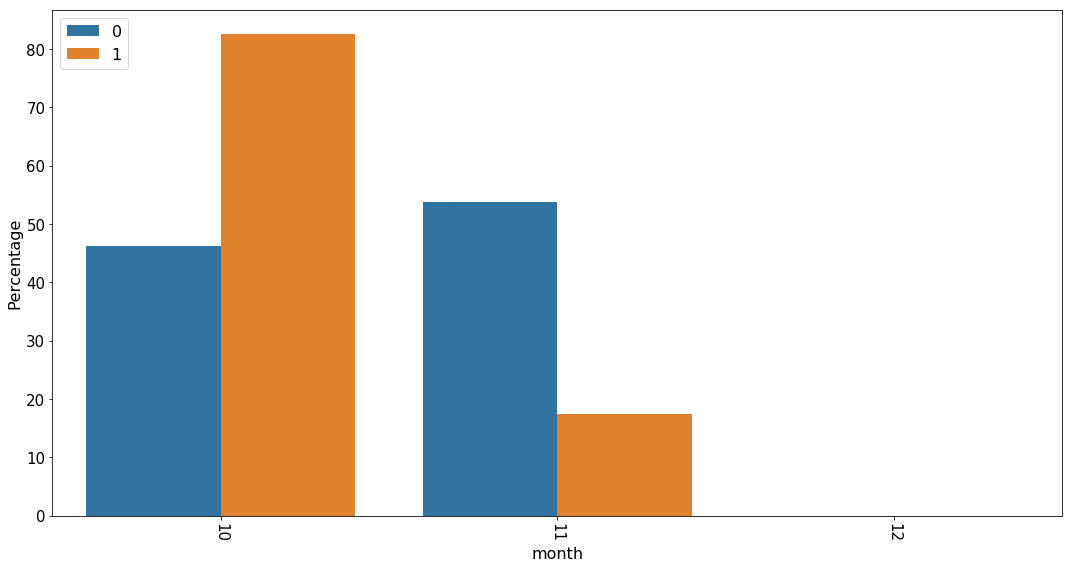

In [69]:
vis_dist_percentage(df_clean, 'month')

From the plots above, we can conclude that, for the distribution of events in different hours, the overall trend is similar for both groups of users and we don't observe a significant difference. One thing notable is that churned users have a generally higher tendancy to visit pages during the afternoon/evening than in the morning. The churned users are more active on Thursday and Friday while the other users are more active on Sunday. Although we can see a big difference of the distributions of the two groups of users in terms of months, there are only data in two months, this may not be so helpful.

For the numerical part, we want to explore if the total time listening to songs will affect churning. Also, the number of artist listened to, the number of sessions, and the number of days registered are of interests.

In [70]:
df_length = df_clean.select('userID', 'length').groupBy('userID').sum()
df_length = df_length.withColumn('churn', is_churn_udf('userID'))
df_length = df_length.toPandas()

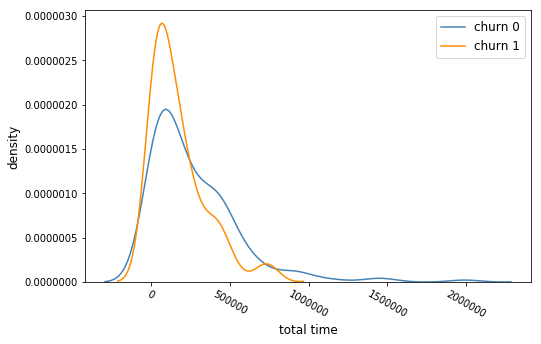

In [71]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.kdeplot(df_length.loc[df_length['churn'] == 0, 'sum(length)'], color = 'steelblue')
sns.kdeplot(df_length.loc[df_length['churn'] == 1, 'sum(length)'], color = 'darkorange')
ax.set_ylabel('density', fontsize = 12)
ax.set_xlabel('total time', fontsize = 12)
ax.tick_params(axis='y', labelsize = 10)
ax.tick_params(axis='x', labelsize = 10, rotation = -30)
ax.legend(['churn 0', 'churn 1'], loc = 0, fontsize = 12)
plt.show()
plt.savefig('figs/total_time.png', dpi=300, bbox_inches='tight')

In [72]:
def vis_dist_num(df, col):
    '''
    Function to visualize the distribution patterns in percentage based on two user groups in the dataset
     
    Args:
        df: a spark Dataframe
        col: a string, the name of the column to visualize
        
    Returns:
        None
    '''
    
    df_temp = df.dropDuplicates(['userID', col]).groupBy('userID').count()
    df_temp = df_temp.withColumn('churn', is_churn_udf('userID'))
    df_temp = df_temp.toPandas()
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.kdeplot(df_temp.loc[df_temp['churn'] == 0, 'count'], color = 'steelblue')
    sns.kdeplot(df_temp.loc[df_temp['churn'] == 1, 'count'], color = 'darkorange')
    ax.set_ylabel('density', fontsize = 12)
    ax.set_xlabel(col+' count', fontsize = 12)
    ax.tick_params(axis='y', labelsize = 10)
    ax.tick_params(axis='x', labelsize = 10, rotation = -30)
    ax.legend(['churn 0', 'churn 1'], loc = 0, fontsize = 12)
    plt.show()
    plt.savefig('figs/%s_dist.png' % col, dpi=300, bbox_inches='tight')

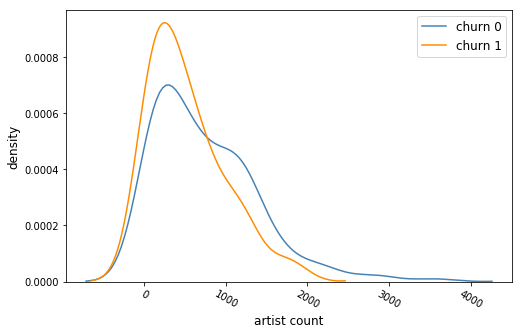

In [73]:
vis_dist_num(df_clean, 'artist')

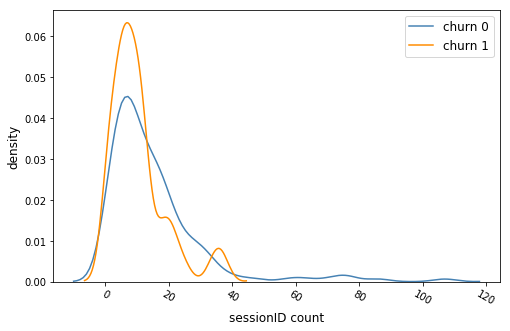

In [74]:
vis_dist_num(df_clean, 'sessionID')

In [75]:
reg_time = df_clean.select('userID', 'registration').dropDuplicates()
last_act = df_clean.select('userID', 'ts').groupBy('userID').max()
reg_time = reg_time.join(last_act, 'userID')

reg_time = reg_time.withColumn('regDays', 
                               (reg_time['max(ts)'] - reg_time['registration']) / (1000 * 60 * 60 * 24))
reg_time = reg_time.drop('registration', 'max(ts)')

reg_time.show()

+------+------------------+
|userID|           regDays|
+------+------------------+
|100010| 55.64365740740741|
|200002| 70.07462962962963|
|   125| 71.31688657407408|
|   124|131.55591435185184|
|    51|19.455844907407407|
|     7| 72.77818287037037|
|    15|56.513576388888886|
|    54|110.75168981481481|
|   155|23.556018518518517|
|100014| 85.08340277777778|
|   132|  66.8891087962963|
|   154|23.872037037037035|
|   101|        53.9659375|
|    11|124.47825231481481|
|   138| 66.62668981481481|
|300017| 74.35851851851852|
|100021| 64.73886574074074|
|    29|60.104050925925925|
|    69| 71.42444444444445|
|   112| 87.46262731481481|
+------+------------------+
only showing top 20 rows



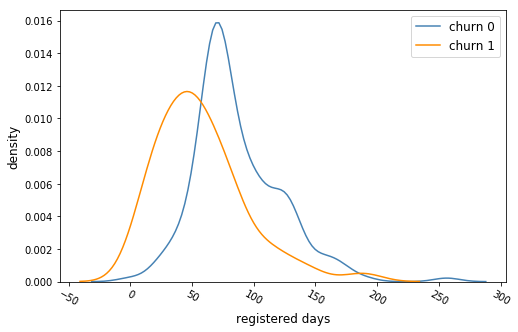

In [76]:
reg_time = reg_time.withColumn('churn', is_churn_udf('userID'))
reg_time = reg_time.toPandas()
fig, ax = plt.subplots(figsize=(8, 5))
sns.kdeplot(reg_time.loc[reg_time['churn'] == 0, 'regDays'], color = 'steelblue')
sns.kdeplot(reg_time.loc[reg_time['churn'] == 1, 'regDays'], color = 'darkorange')
ax.set_ylabel('density', fontsize = 12)
ax.set_xlabel('registered days', fontsize = 12)
ax.tick_params(axis='y', labelsize = 10)
ax.tick_params(axis='x', labelsize = 10, rotation = -30)
ax.legend(['churn 0', 'churn 1'], loc = 0, fontsize = 12)
plt.show()
plt.savefig('figs/registered_days.png', dpi=300, bbox_inches='tight')

It is clearly shown above that the two groups of users show different behaviors in the total time spent on listening to songs, the number of artist listened to, the number of sessions, and the number of days registered.

# Feature Engineering
With the EDA above, we have observed several useful features which can be used in training the model to predict churning, including both the numerical and categorical features.
Right now, we will consider the following features:<br/>
Categorical:
* Gender
* Level
* Platform
* State

Numerical:
* Total time on listening to songs
* Number of sessions
* Number of total events
* Number of `Thumbs Up` events (since we know the total number of events, the model is knowledgeable of the ratio)
* Number of `Thumbs Down` events
* Number of `Add Friend` events
* Number of `Add to Playlist` events
* Number of `Roll Advert` events
* Number of `NextSong` events
* Ratio of events in the first half of the day
* Number of artists listened to
* Time since registration

### Categorical Features
* Gender
* Level
* Platform
* State

In [77]:
# Create the basic dataframe with the userID, gender, and churn column
data = df_clean.dropDuplicates(['userID']).select('userID', 'gender', 'churn')

In [78]:
# Add the level, platform, and location (state) of the last activity of the user
df_clean = df_clean.orderBy('userID', 'ts', ascending = False)
df_cat = df_clean.dropDuplicates(['userID']).select('userID', 'level', 'platform', 'state')

data = data.join(df_cat, 'userID')

### Numerical Features
* Time on listening to songs per event
* Number of events per session
* Number of total events
* Ratio of `Thumbs Up` events (since we know the total number of events, the model is knowledgeable of the number of each events)
* Ratio of `Thumbs Down` events
* Ratio of `Add Friend` events
* Ratio of `Add to Playlist` events
* Ratio of `Roll Advert` events
* Ratio of `NextSong` events
* Number of artists listened to
* Ratio of events in the first half of the day
* Time since registration

In [79]:
# Extract the total time of each user listening to songs
df_time = df_clean.groupBy(['userID']).sum('length').withColumnRenamed('sum(length)', 'totalTime')

df_time.show(5)

+------+------------------+
|userID|         totalTime|
+------+------------------+
|200002| 94008.87593999998|
|100010| 66940.89735000003|
|   125|         2089.1131|
|     7|        38034.0871|
|    51|523275.84279999946|
+------+------------------+
only showing top 5 rows



In [80]:
# Extract the number of sessions of each user
df_session = df_clean.dropDuplicates(['userID', 'sessionID']).groupBy('userID').count()\
.withColumnRenamed('count', 'numSessions')

df_session.show(5)

+------+-----------+
|userID|numSessions|
+------+-----------+
|100010|          7|
|200002|          6|
|   125|          1|
|    51|         10|
|   124|         29|
+------+-----------+
only showing top 5 rows



In [81]:
# Extract the number of events of each user
def extract_events(df, col, event_name):
    '''
    '''
    
    df_event = df.filter(df[col] == event_name).groupBy('userID').count().\
    withColumnRenamed('count', 'num'+event_name.replace(' ', ''))
    
    return df_event

In [82]:
events = ['Add Friend', 'Add to Playlist', 'NextSong', 'Roll Advert', 'Thumbs Down', 'Thumbs Up']

for event in events:
    df_temp = extract_events(df_clean, 'page', event)
    data = data.join(extract_events(df_clean, 'page', event), 'userID')

In [83]:
# Extract the total number of events of each user
df_events = df_clean.groupBy('userID').count().withColumnRenamed('count', 'numEvents')

df_events.show(5)

+------+---------+
|userID|numEvents|
+------+---------+
|200002|      474|
|100010|      381|
|   125|       11|
|     7|      201|
|    51|     2464|
+------+---------+
only showing top 5 rows



In [84]:
# Extract the number of events in the first half of the day
df_hour = df_clean.filter((df_clean['hour'] >= 1) & (df_clean['hour'] <= 12)).groupBy('userID').count()\
.withColumnRenamed('count', 'numFirstHalf')

df_hour.show(5)

+------+------------+
|userID|numFirstHalf|
+------+------------+
|200002|         113|
|100010|         186|
|   125|          11|
|     7|         130|
|    51|        1128|
+------+------------+
only showing top 5 rows



In [85]:
# Extract the number of artists that each user listened to
df_artist = df_clean.dropDuplicates(['userID', 'artist']).groupBy('userID').count()\
.withColumnRenamed('count', 'numArtists')

df_artist.show(5)

+------+----------+
|userID|numArtists|
+------+----------+
|200002|       340|
|100010|       253|
|   125|         9|
|    51|      1386|
|   124|      2233|
+------+----------+
only showing top 5 rows



In [86]:
# Extract the time period since registration for each user
df_reg = df_clean.select('userID', 'registration').dropDuplicates()
last_ts = df_clean.select('userID', 'ts').groupBy('userID').max()
df_reg = df_reg.join(last_ts, 'userID')

df_reg = df_reg.withColumn('regDays', 
                           (df_reg['max(ts)'] - df_reg['registration']) / (1000 * 60 * 60 * 24))

df_reg = df_reg.drop('registration', 'max(ts)')

df_reg.show(5)

+------+------------------+
|userID|           regDays|
+------+------------------+
|100010| 55.64365740740741|
|200002| 70.07462962962963|
|   125| 71.31688657407408|
|   124|131.55591435185184|
|    51|19.455844907407407|
+------+------------------+
only showing top 5 rows



In [87]:
# Combine these features
for df_temp in [df_time, df_session, df_events, df_hour, df_artist, df_reg]:
    data = data.join(df_temp, 'userID')

In [88]:
# Tansform the numbers into ratios
numCols = ['numAddFriend', 'numAddtoPlaylist', 'numNextSong', 'numRollAdvert', 
           'numThumbsDown', 'numThumbsUp', 'numFirstHalf', 'numArtists']

for numCol in numCols:
    data = data.withColumn('ratio' + numCol[3:], (data[numCol] / data['numEvents']))
    data = data.drop(numCol)

In [89]:
data = data.withColumn('numPerSession', (data['numEvents'] / data['numSessions']))
data = data.withColumn('timePerEvent', (data['totalTime'] / data['numEvents']))
data = data.drop('numSessions')
data = data.drop('totalTime')

Before proceeding, we first check if there's any missing data here and the correlations between all columns.

In [90]:
from pyspark.sql.functions import isnan, when, count, col
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+------+------+-----+-----+--------+-----+---------+-------+--------------+------------------+-------------+---------------+---------------+-------------+--------------+------------+-------------+------------+
|userID|gender|churn|level|platform|state|numEvents|regDays|ratioAddFriend|ratioAddtoPlaylist|ratioNextSong|ratioRollAdvert|ratioThumbsDown|ratioThumbsUp|ratioFirstHalf|ratioArtists|numPerSession|timePerEvent|
+------+------+-----+-----+--------+-----+---------+-------+--------------+------------------+-------------+---------------+---------------+-------------+--------------+------------+-------------+------------+
|     0|     0|    0|    0|       0|    0|        0|      0|             0|                 0|            0|              0|              0|            0|             0|           0|            0|           0|
+------+------+-----+-----+--------+-----+---------+-------+--------------+------------------+-------------+---------------+---------------+-------------+------

In [91]:
data.show(5, False)

+------+------+-----+-----+--------------+-----+---------+------------------+--------------------+--------------------+------------------+--------------------+--------------------+-------------------+-------------------+------------------+------------------+------------------+
|userID|gender|churn|level|platform      |state|numEvents|regDays           |ratioAddFriend      |ratioAddtoPlaylist  |ratioNextSong     |ratioRollAdvert     |ratioThumbsDown     |ratioThumbsUp      |ratioFirstHalf     |ratioArtists      |numPerSession     |timePerEvent      |
+------+------+-----+-----+--------------+-----+---------+------------------+--------------------+--------------------+------------------+--------------------+--------------------+-------------------+-------------------+------------------+------------------+------------------+
|100010|F     |0    |free |iPhone        |CT   |381      |55.64365740740741 |0.010498687664041995|0.01837270341207349 |0.7217847769028871|0.13648293963254593 |0.01312

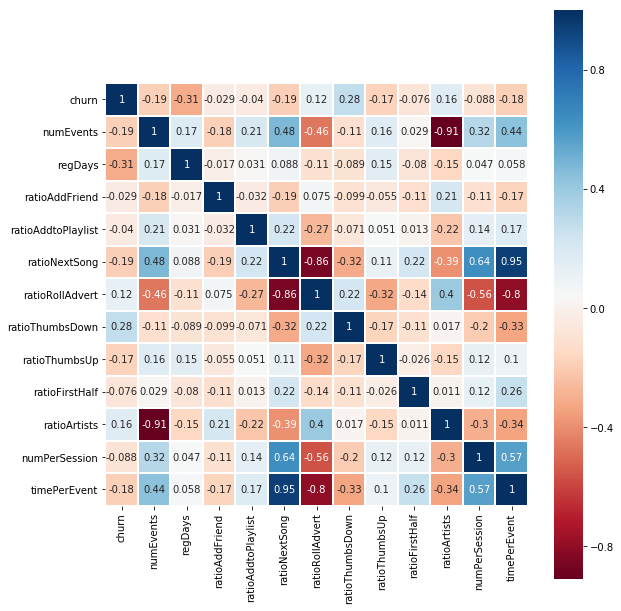

In [92]:
fig, ax = plt.subplots(figsize=(9, 9))
ax = sns.heatmap(data.toPandas().corr(), cmap='RdBu', linewidths = 1, square = True, annot = True)
plt.tight_layout()
plt.show()
plt.savefig('figs/corr.png', dpi=300, bbox_inches='tight')

Looks good! There are only few pairs of features are highly correlated like ratioNextSong vs timePerEvent, ratioArtists vs numEvents, and ratioRollAdvert vs ratioNextSong.

In [93]:
# Save the dataframe
data.write.csv('cleaned_data.csv', mode = 'overwrite', header = True)

# Modeling
With the features extracted, we are ready to train the model. In the following section, we'll start with creating a pipeline for preparation of data for modeling. After that, we'll divide the full dataset into the train and test sets. Several machine learning methods will be tested with parameters tuned and metrics evaluated. Due to the skewd distribution of churing, the F1 score will be used for model comparison.

### Data Preparation

In [94]:
# Define the pipeline to create the training data

# Create the one-hot encodings for the categorical features
etl_stages = []

categorical_cols = ['gender', 'level', 'platform', 'state']
numerical_cols = [col for col in data.columns if col not in categorical_cols]
numerical_cols.remove('churn')
numerical_cols.remove('userID')

for categorical_col in categorical_cols:
    stringIndexer = StringIndexer(inputCol=categorical_col, outputCol=categorical_col + 'Index', 
                                  stringOrderType='alphabetDesc')
    etl_stages.append(stringIndexer)
    
encoder = OneHotEncoderEstimator(inputCols=[col + 'Index' for col in categorical_cols], 
                                 outputCols=[col + 'Vec' for col in categorical_cols])
etl_stages.append(encoder)

# Combine all the features
assembler = VectorAssembler(inputCols=[col + 'Vec' for col in categorical_cols] + numerical_cols,
                            outputCol='features')
etl_stages.append(assembler)

# Create the pipeline
etl_pipeline = Pipeline(stages=etl_stages)

In [95]:
# Split the dataset into train and test sets
data_cleaned = spark.read.csv('cleaned_data.csv', inferSchema = True, header=True)

data_cleaned = etl_pipeline.fit(data_cleaned).transform(data_cleaned)

train, test = data_cleaned.randomSplit([0.7, 0.3])

In [96]:
# Initialize the random forest classifier for a trial fitting
rf_trial = RandomForestClassifier(labelCol='churn', featuresCol='features', numTrees=5)
model_trial = rf_trial.fit(train)

In [97]:
# Check the metrics
pred_train = model_trial.transform(train)
pred_test = model_trial.transform(test)

predictionAndLabels = pred_train.rdd.map(lambda lp: (float(lp.prediction), float(lp.churn)))
print('F1 score for the training data is %.3f.' % (MulticlassMetrics(predictionAndLabels).fMeasure()))

predictionAndLabels = pred_test.rdd.map(lambda lp: (float(lp.prediction), float(lp.churn)))
print('F1 score for the test data is %.3f.' % (MulticlassMetrics(predictionAndLabels).fMeasure()))

acc_eval = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='churn')
print('The accuracy for the training data is %.3f.' % (acc_eval.evaluate(pred_train)))
print('The accuracy for the test data is %.3f.' % (acc_eval.evaluate(pred_test)))

F1 score for the training data is 0.927.
F1 score for the test data is 0.792.
The accuracy for the training data is 0.977.
The accuracy for the test data is 0.703.


### Model selection
With the data prepared, we're ready to test different models with the hyper-parameters tuned. Since we find that the distribution of the churn is skewed, the F1 score is used to choose between models.

In [98]:
# Logistic regression
lr = LogisticRegression(labelCol='churn')

# param_grid_lr = ParamGridBuilder() \
#     .baseOn({lr.labelCol: 'churn'}) \
#     .addGrid(lr.regParam, [0, 0.01, 0.03, 0.1, 0.3]) \
#     .addGrid(lr.elasticNetParam, [0, 0.1, 0.5]) \
#     .addGrid(lr.standardization, [True, False]) \
#     .addGrid(lr.aggregationDepth, [2, 5, 10]) \
#     .build()

param_grid_lr = ParamGridBuilder() \
    .addGrid(lr.aggregationDepth, [2, 10]) \
    .addGrid(lr.elasticNetParam, [0, 0.3]) \
    .addGrid(lr.regParam, [0.01, 0.1, 0.3]) \
    .build()

cv_lr = CrossValidator(estimator=lr, estimatorParamMaps=param_grid_lr, 
                       evaluator=MulticlassClassificationEvaluator(labelCol='churn'), 
                       numFolds=3, seed=35)

lr_model = cv_lr.fit(train)

In [99]:
def sum_models_performance(model, labels):
    '''
    Function to summarize the hyper-parameters with the scores for the models into a Dataframe
     
    Args:
        model: a fitted CrossValidatorModel
        labels: a list of strings, the name of the metric and the hyper-parameters
        
    Returns:
        df: a Dataframe containing the hyper-parameters with the scores for the models
    '''
    
    df_lists = []
    
    for i, grid in enumerate(model.getEstimatorParamMaps()):
        df_list = []
        df_list.append(model.avgMetrics[i])
        for param in grid.values():
            df_list.append(param)
        df_lists.append(df_list)
        
    df = pd.DataFrame.from_records(df_lists, columns=labels)
    return df

In [100]:
def test_metrics(model):
    '''
    Function to check the performance of the best model on the test set
     
    Args:
        model: a fitted CrossValidatorModel
        
    Returns:
        None
    '''
    
    pred = model.bestModel.transform(test)
    
    print('The F1 score for the test set is %.3f.' % MulticlassClassificationEvaluator(
        predictionCol='prediction', labelCol='churn').evaluate(pred))
    
    print('The accuracy for the test set is %.3f.' % MulticlassClassificationEvaluator(
        predictionCol='prediction', labelCol='churn', metricName='accuracy').evaluate(pred))

In [101]:
# Visualize the confusion matirx
def plot_cm(model, labels, normalize = False, title = None, cmap = plt.cm.Blues):
    '''
    Function to visualize the confusion matrix
     
    Args:
        model: a fitted CrossValidatorModel
        labels: a list of strings for the labels
        normalize: Boolean, if normalize the confusion matrix (default: False)
        title: the title for the plot (default: None)
        cmap: color map for the confusion matrix (default: plt.cm.Blues)
        
    Returns:
        None
    '''
    
    if not title:
        if normalize:
            title = "Confusion matrix with normalization"
        else:
            title = "Confusion matrix"
            
    predictions = model.bestModel.transform(test)
    predictionAndLabels = predictions.rdd.map(lambda lp: (float(lp.prediction), float(lp.churn)))
    cm = MulticlassMetrics(predictionAndLabels).confusionMatrix().toArray()

    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize = (15, 6))
    im = ax.imshow(cm, interpolation = "nearest", cmap = cmap, aspect = 0.6)
    ax.figure.colorbar(im, ax = ax)

    ax.set(xticks = np.arange(cm.shape[1]),
           yticks = np.arange(cm.shape[0]),
           xticklabels = labels, 
           yticklabels = labels,
           title = title,
           ylabel = "Actual",
           xlabel = "Prediction")

    plt.setp(ax.get_xticklabels(), rotation = 0, ha = "center", rotation_mode = "anchor")

    fmt = ".3f" if normalize else ".1f"
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha = "center", va = "center",
                    color = "white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    plt.show()
    plt.savefig('figs/%s_cm.png' % model.bestModel, dpi=300, bbox_inches='tight')

In [102]:
sum_models_performance(lr_model, ['F1 score', 'regParam', 'elasticNetParam', 'aggregationDepth'])

,F1 score,regParam,elasticNetParam,aggregationDepth
0,0.727588,2,0.0,0.01
1,0.709767,2,0.0,0.10
2,0.723758,2,0.0,0.30
3,0.735208,2,0.3,0.01
4,0.735683,2,0.3,0.10
5,0.713072,2,0.3,0.30
6,0.727588,10,0.0,0.01
7,0.709767,10,0.0,0.10
8,0.723758,10,0.0,0.30
9,0.735208,10,0.3,0.01


In [103]:
test_metrics(lr_model)

The F1 score for the test set is 0.654.
The accuracy for the test set is 0.736.


Normalized confusion matrix
[[ 0.97435897  0.02564103]
 [ 0.92857143  0.07142857]]


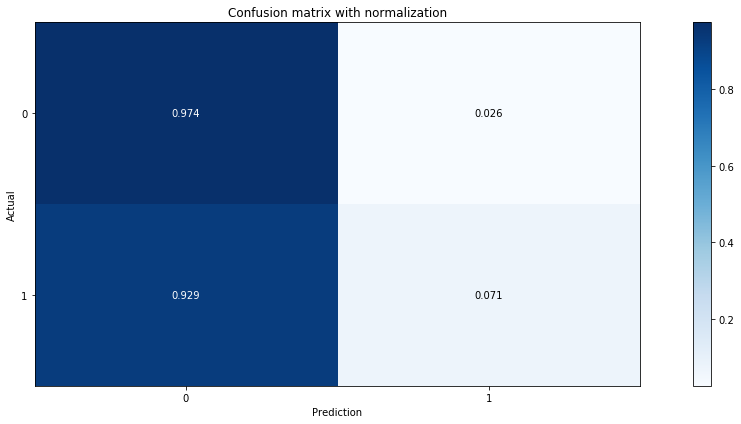

In [104]:
plot_cm(lr_model, labels = ["0", "1"], normalize = True)

In [105]:
# Random Forest
rf = RandomForestClassifier(labelCol='churn')

param_grid_rf = ParamGridBuilder() \
    .addGrid(rf.featureSubsetStrategy, ['sqrt', 'all']) \
    .addGrid(rf.impurity, ['entropy', 'gini']) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .addGrid(rf.numTrees, [10, 20]) \
    .build()

cv_rf = CrossValidator(estimator=rf, estimatorParamMaps=param_grid_rf, 
                       evaluator=MulticlassClassificationEvaluator(labelCol='churn'), 
                       numFolds=3, seed=35)

rf_model = cv_rf.fit(train)

In [106]:
sum_models_performance(rf_model, ['F1 score', 'featureSubsetStrategy', 'impurity', 'maxDepth', 'numTrees'])

,F1 score,featureSubsetStrategy,impurity,maxDepth,numTrees
0,0.747620,sqrt,entropy,5,10
1,0.780343,sqrt,entropy,5,20
2,0.747115,sqrt,entropy,10,10
3,0.765393,sqrt,entropy,10,20
4,0.749935,sqrt,gini,5,10
5,0.753790,sqrt,gini,5,20
6,0.750459,sqrt,gini,10,10
7,0.740382,sqrt,gini,10,20
8,0.843216,all,entropy,5,10
9,0.844269,all,entropy,5,20


In [107]:
test_metrics(rf_model)

The F1 score for the test set is 0.751.
The accuracy for the test set is 0.774.


Normalized confusion matrix
[[ 0.92307692  0.07692308]
 [ 0.64285714  0.35714286]]


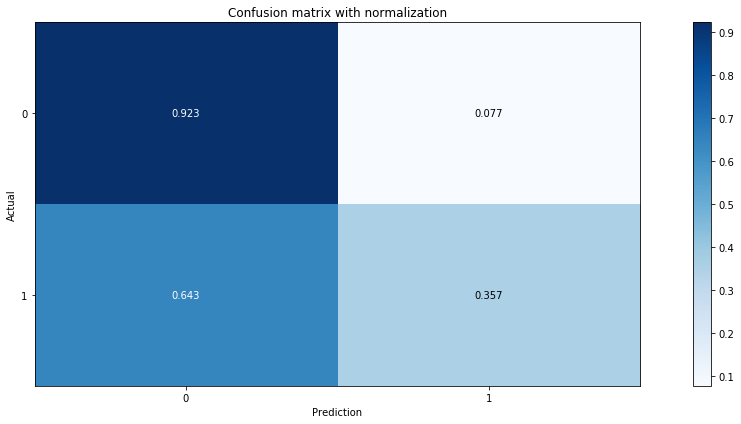

In [108]:
plot_cm(rf_model, labels = ["0", "1"], normalize = True)

In [109]:
# Gradient Boosting Trees
gbt = GBTClassifier(labelCol='churn')

param_grid_gbt = ParamGridBuilder() \
    .addGrid(gbt.featureSubsetStrategy, ['sqrt', 'all']) \
    .addGrid(gbt.maxIter, [10, 20]) \
    .addGrid(gbt.maxDepth, [5, 10]) \
    .addGrid(gbt.stepSize, [0.1, 0.3]) \
    .build()

cv_gbt = CrossValidator(estimator=gbt, estimatorParamMaps=param_grid_gbt, 
                        evaluator=MulticlassClassificationEvaluator(labelCol='churn'), 
                        numFolds=3, seed=35)

gbt_model = cv_gbt.fit(train)

In [110]:
sum_models_performance(gbt_model, ['F1 score', 'featureSubsetStrategy', 'maxIter', 'maxDepth', 'stepSize'])

,F1 score,featureSubsetStrategy,maxIter,maxDepth,stepSize
0,0.758980,sqrt,10,5,0.1
1,0.769795,sqrt,10,5,0.3
2,0.747458,sqrt,10,10,0.1
3,0.747458,sqrt,10,10,0.3
4,0.765964,sqrt,20,5,0.1
5,0.769795,sqrt,20,5,0.3
6,0.747458,sqrt,20,10,0.1
7,0.752031,sqrt,20,10,0.3
8,0.797801,all,10,5,0.1
9,0.797801,all,10,5,0.3


In [111]:
test_metrics(gbt_model)

The F1 score for the test set is 0.683.
The accuracy for the test set is 0.679.


Normalized confusion matrix
[[ 0.76923077  0.23076923]
 [ 0.57142857  0.42857143]]


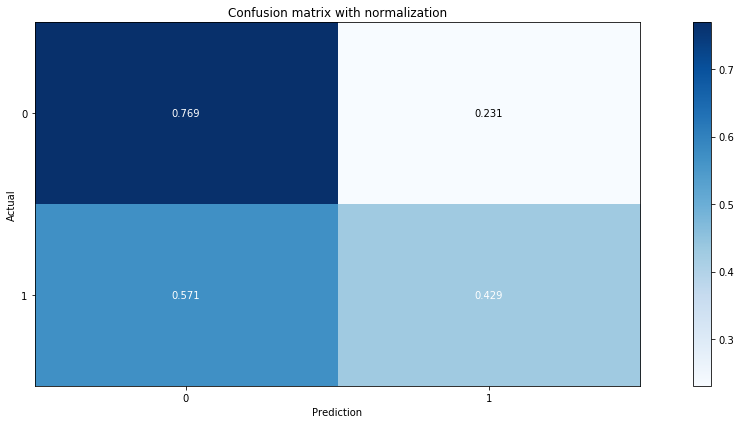

In [112]:
plot_cm(gbt_model, labels = ["0", "1"], normalize = True)

In [113]:
# Naive Bayes
nb = NaiveBayes(labelCol='churn')

param_grid_nb = ParamGridBuilder() \
    .addGrid(nb.smoothing, [0, 1, 5]) \
    .build()

cv_nb = CrossValidator(estimator=nb, estimatorParamMaps=param_grid_nb, 
                       evaluator=MulticlassClassificationEvaluator(labelCol='churn'), 
                       numFolds=3, seed=35)

nb_model = cv_nb.fit(train)

In [114]:
sum_models_performance(nb_model, ['F1 score', 'smoothing'])

,F1 score,smoothing
0,0.687572,0.0
1,0.606974,1.0
2,0.655926,5.0


In [115]:
test_metrics(nb_model)

The F1 score for the test set is 0.720.
The accuracy for the test set is 0.717.


Normalized confusion matrix
[[ 0.79487179  0.20512821]
 [ 0.5         0.5       ]]


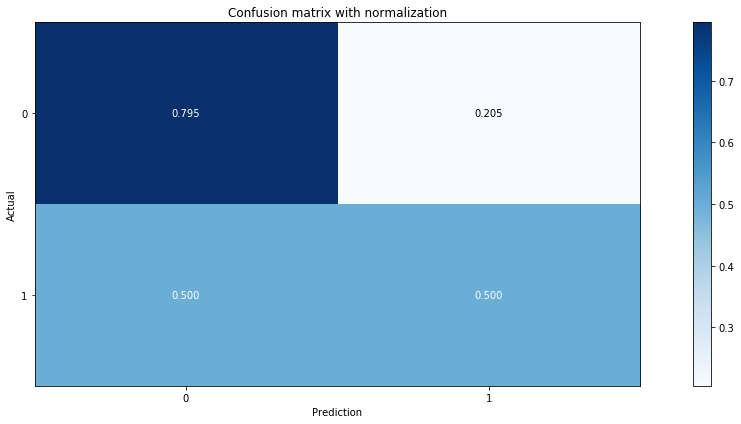

In [116]:
plot_cm(nb_model, labels = ["0", "1"], normalize = True)